# Data Processing

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Process Data

### Step 1 - Split matches into point segments

Starting from the full match videos and the annotations, we split them into shorter segments containing a single point.

In [2]:
# Import libraries
import os
import json
import cv2
from tqdm import tqdm

In [3]:
# Constants
from __init__ import data_path
# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
videos_path = os.path.join(dataset_path, "videos")
annotations_path = os.path.join(dataset_path, "annotations")

# Read videos
videos = sorted(os.listdir(videos_path))
print("___VIDEOS___")
for video in videos: print(video)

# Determine where to save segments
segments_path = os.path.join(dataset_path, "segments_alt")
os.makedirs(segments_path, exist_ok=True)

___VIDEOS___
V006.mp4
V007.mp4
V008.mp4
V009.mp4
V010.mp4


In [3]:
def segment_video(
    video, 
    segment_by="Point", 
    videos_path=videos_path, 
    annotations_path=annotations_path, 
    segments_path=segments_path,
    overwrite=False,
):
    # Video & annotation path
    video_name, video_ext = os.path.splitext(video)
    video_path = os.path.join(videos_path, video)
    annotation_path = os.path.join(annotations_path, video.replace(video_ext, ".json"))

    # Load annotation
    with open(annotation_path) as annotation_file:
        annotation = json.load(annotation_file)

    # Load video
    capture = cv2.VideoCapture(video_path)
    frame = 0

    # Get resolution & framerate from capture
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    # Perform segmentation
    segments = annotation["classes"][segment_by]
    for index, segment in tqdm(enumerate(segments)):
        # Determine path to save current segment
        segment_nr = f"{index}".zfill(4)
        segment_name = f"{video_name}_{segment_nr}"
        segment_path = os.path.join(segments_path, f"{segment_name}.mp4")

        # Don't overwrite if not needed
        if os.path.exists(segment_path) and not overwrite:
            continue

        # Open video writer
        writer = cv2.VideoWriter(segment_path, cv2.VideoWriter_fourcc(*"avc1"), fps, (frame_width, frame_height))

        # segment points
        start, end = int(segment["start"]), int(segment["end"])

        # Fast forward to start of segment
        frame = start
        capture.set(1, frame)
        
        # Save frames to segment
        while_safety = 0
        max_while_safety = 500
        while frame < end:
            # Read frame
            ret, img = capture.read()

            # Sometimes OpenCV reads None's during a video, in which case we want to just skip
            assert while_safety < max_while_safety, f"ERROR, cv2 read {max_while_safety} Nones"
            if ret == 0 or img is None: 
                while_safety += 1
                continue 
            while_safety = 0

            # Write frame
            writer.write(img)

            # Increase frame counter
            frame += 1
        
        # Release writer
        writer.release()
    

In [ ]:
segment_video(videos[0], overwrite=True)

In [ ]:
for video in videos:
    print(f"Segmenting video {video}")
    segment_video(video, overwrite=True)

In [ ]:
segment_files = [f for f in os.listdir(segments_path) if f.endswith('.mp4')]
n_segments = len(segment_files)
total_frames = 0
total_duration = 0
for segment in segment_files:
    segment_path = os.path.join(segments_path, segment)
    # Give the duration and number of frames of the video
    data = cv2.VideoCapture(segment_path) 
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT) 
    fps = data.get(cv2.CAP_PROP_FPS)
    
    # calculate duration of the video 
    duration = frames / fps

    # Add to total
    total_frames += frames
    total_duration += duration

print(f"Total number of videos: {n_segments}")
print(f"Total number of frames: {total_frames}")
print(f"Total duration: {total_duration / 60 / 60:.2f} hours")
print(f"Average duration per video: {total_duration / n_segments:.2f} seconds")

### Step 2 - Court, Player & Ball Detection

In [2]:
# Import libaries
import os
import sys
import cv2
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {device}")

Using device cuda


We make use of the pre-trained models provided by the tennis-project repository:
- [Ball Detection](https://drive.google.com/file/d/1XEYZ4myUN7QT-NeBYJI0xteLsvs-ZAOl/view): Save as `models/data/ball_detection/model.pt`
- [Court Detection](https://drive.google.com/file/d/1f-Co64ehgq4uddcQm1aFBDtbnyZhQvgG/view): Save as `models/data/court_detection/model.pt`

In [3]:
# Constants
from __init__ import data_path, models_path

# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments")
labels_path = os.path.join(dataset_path, "labels")
os.makedirs(labels_path, exist_ok=True)

# Model paths
model_ball_detection_path = os.path.join(models_path, "ball_detection", "model.pt")
model_court_detection_path = os.path.join(models_path, "court_detection", "model.pt")
assert os.path.exists(model_ball_detection_path), "Please download model"
assert os.path.exists(model_court_detection_path), "Please download model"

In [4]:
# Import tennis-project objects
cwd = os.getcwd()
tennis_project_path = os.path.abspath(os.path.join(cwd, "tennis-project"))
sys.path.append(tennis_project_path)
from court_detection_net import CourtDetectorNet
from court_reference import CourtReference
from bounce_detector import BounceDetector
from person_detector import PersonDetector
from ball_detector import BallDetector
from utils import scene_detect
from main import read_video
from main import get_court_img

/opt/conda/envs/teco/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Read segment files
segment_files = [file for file in sorted(os.listdir(segments_path)) if os.path.splitext(file)[-1] == ".mp4"]
print(f"Number of segment files: {len(segment_files)}")

Number of segment files: 746


In [18]:
def process_segment(
    segment_path, 
    labels_path = labels_path, 
    verbose = True,
    overwrite=False,
):
    # Start
    start_time = time.time()

    # Check if segment already processed (by last saved file)
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    if os.path.exists(os.path.join(labels_path, f"{segment_name}_ball.npy")) and not overwrite:
        #if verbose: print(f"Segment {segment_name} already processed")
        return
    if verbose: print(f"Processing segment: {segment_name}")

    # Read video
    if verbose: print("Reading video")
    frames, fps =  read_video(segment_path)
    frames = frames
    video_time = time.time()
    if verbose: print(f"Done reading {len(frames)} video frames ({video_time - start_time} s)")

    # Load models
    if verbose: print("Loading models")
    ball_detector = BallDetector(model_ball_detection_path, device)
    court_detector = CourtDetectorNet(model_court_detection_path, device)
    person_detector = PersonDetector(device)
    models_time = time.time()
    if verbose: print(f"Done loading models ({models_time - video_time} s)")

    # Detect court 
    if verbose: print("Detecting court")
    homography_matrices, kps_court = court_detector.infer_model(frames)
    court_time = time.time()
    if verbose: print(f"Done detecting court ({court_time - models_time} s)")
    
    # Detect whether frames are valid (i.e. court is detected)
    frames_is_valid = np.array([not detection is None for detection in kps_court])
    frames = [frame for frame, frame_is_valid in zip(frames, frames_is_valid) if frame_is_valid]
    homography_matrices = [matrix for matrix, frame_is_valid in zip(homography_matrices, frames_is_valid) if frame_is_valid]
    kps_court = [points for points, frame_is_valid in zip(kps_court, frames_is_valid) if frame_is_valid]

    # Detect people
    if verbose: print("Detecting people")
    persons_top, persons_bottom = person_detector.track_players(frames, homography_matrices, filter_players=False)
    people_time = time.time()
    if verbose: print(f"Done detecting people ({people_time - court_time} s)")

    # Detect ball trajectory
    if verbose: print("Detecting ball trajectory")
    ball_track = ball_detector.infer_model(frames)
    ball_time = time.time()
    if verbose: print(f"Done detecting ball trajectory ({ball_time - people_time} s)")

    # Export labels
    if verbose: print("Saving results")
    # Save frame validities
    frames_is_valid_file = os.path.join(labels_path, f"{segment_name}_frame_validity.npy")
    np.save(frames_is_valid_file, frames_is_valid)
    # Save court
    court_file = os.path.join(labels_path, f"{segment_name}_court.npy")
    court_sequence = np.squeeze(np.array(kps_court))
    np.save(court_file, court_sequence)
    # Save players
    for player_name, player_sequence in zip(["btm", "top"], [persons_bottom, persons_top]):
        player_file = os.path.join(labels_path, f"{segment_name}_player_{player_name}_bbox.npy")
        player_sequence = np.array([item[0][0] if len(item) else [None] * 4 for item in player_sequence])
        np.save(player_file, player_sequence)
    # Save ball trajectory
    ball_file = os.path.join(labels_path, f"{segment_name}_ball.npy")
    ball_sequence = np.array(ball_track)
    np.save(ball_file, ball_sequence)
    save_time = time.time()
    if verbose: print(f"Done detecting ball trajectory ({save_time - ball_time} s)")
    if verbose: print(f"Total time: {save_time - start_time} s")

In [19]:
process_segment(os.path.join(segments_path, segment_files[0]), overwrite=False, verbose=True)

In [20]:
for i, segment_file in enumerate(segment_files):
    process_segment(os.path.join(segments_path, segment_file), overwrite=False, verbose=True)

Processing segment: V007_0022
Reading video
Done reading 236 video frames (0.5299117565155029 s)
Loading models
Done loading models (1.0037474632263184 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:33<00:00,  7.05it/s]


Done detecting court (33.479904651641846 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:32<00:00,  7.22it/s]


Done detecting people (32.709535121917725 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:21<00:00, 10.83it/s]


Done detecting ball trajectory (21.618294715881348 s)
Saving results
Done detecting ball trajectory (0.0029594898223876953 s)
Total time: 89.34435319900513 s
Processing segment: V007_0023
Reading video
Done reading 119 video frames (0.1825871467590332 s)
Loading models
Done loading models (0.9323697090148926 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.35it/s]


Done detecting court (16.186379432678223 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.16it/s]


Done detecting people (16.614392518997192 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.84it/s]


Done detecting ball trajectory (10.79816198348999 s)
Saving results
Done detecting ball trajectory (0.0015401840209960938 s)
Total time: 44.71543097496033 s
Processing segment: V007_0024
Reading video
Done reading 232 video frames (0.31914591789245605 s)
Loading models
Done loading models (1.1277592182159424 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:29<00:00,  7.88it/s]


Done detecting court (29.439216375350952 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [00:24<00:00,  7.17it/s]


Done detecting people (24.282504558563232 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:15<00:00, 10.80it/s]


Done detecting ball trajectory (15.927547693252563 s)
Saving results
Done detecting ball trajectory (0.002607583999633789 s)
Total time: 71.09878134727478 s
Processing segment: V007_0025
Reading video
Done reading 258 video frames (0.34149837493896484 s)
Loading models
Done loading models (0.963024377822876 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:34<00:00,  7.54it/s]


Done detecting court (34.23949980735779 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:36<00:00,  7.12it/s]


Done detecting people (36.21637797355652 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:23<00:00, 10.85it/s]


Done detecting ball trajectory (23.595343828201294 s)
Saving results
Done detecting ball trajectory (0.0027055740356445312 s)
Total time: 95.35844993591309 s
Processing segment: V007_0026
Reading video
Done reading 87 video frames (0.12650775909423828 s)
Loading models
Done loading models (0.9291062355041504 s)
Detecting court


100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.86it/s]


Done detecting court (9.820783853530884 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:09<00:00,  7.19it/s]


Done detecting people (9.592588186264038 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:06<00:00, 11.05it/s]


Done detecting ball trajectory (6.069864511489868 s)
Saving results
Done detecting ball trajectory (0.0012171268463134766 s)
Total time: 26.540067672729492 s
Processing segment: V007_0027
Reading video
Done reading 179 video frames (0.25244593620300293 s)
Loading models
Done loading models (0.9455907344818115 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:22<00:00,  7.85it/s]


Done detecting court (22.80826187133789 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:25<00:00,  7.14it/s]


Done detecting people (25.073713541030884 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [00:16<00:00, 10.82it/s]


Done detecting ball trajectory (16.368775129318237 s)
Saving results
Done detecting ball trajectory (0.002154827117919922 s)
Total time: 65.45094203948975 s
Processing segment: V007_0028
Reading video
Done reading 87 video frames (0.12893414497375488 s)
Loading models
Done loading models (0.9427957534790039 s)
Detecting court


100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.29it/s]


Done detecting court (9.372141599655151 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:09<00:00,  7.21it/s]


Done detecting people (9.156185865402222 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 11.03it/s]


Done detecting ball trajectory (5.805186986923218 s)
Saving results
Done detecting ball trajectory (0.0014104843139648438 s)
Total time: 25.406654834747314 s
Processing segment: V007_0029
Reading video
Done reading 122 video frames (0.18904590606689453 s)
Loading models
Done loading models (0.9235548973083496 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:12<00:00,  9.72it/s]


Done detecting court (12.555094242095947 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  7.30it/s]


Done detecting people (7.128314256668091 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.80it/s]


Done detecting ball trajectory (4.634518146514893 s)
Saving results
Done detecting ball trajectory (0.001684427261352539 s)
Total time: 25.432211875915527 s
Processing segment: V007_0030
Reading video
Done reading 198 video frames (0.298450231552124 s)
Loading models
Done loading models (0.9451954364776611 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:24<00:00,  8.17it/s]


Done detecting court (24.231386423110962 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:27<00:00,  7.15it/s]


Done detecting people (27.678955793380737 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:18<00:00, 10.81it/s]


Done detecting ball trajectory (18.12679386138916 s)
Saving results
Done detecting ball trajectory (0.003313302993774414 s)
Total time: 71.28409504890442 s
Processing segment: V007_0031
Reading video
Done reading 165 video frames (0.2539253234863281 s)
Loading models
Done loading models (0.9282276630401611 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:18<00:00,  9.09it/s]


Done detecting court (18.162561416625977 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.19it/s]


Done detecting people (16.550079345703125 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 10.96it/s]


Done detecting ball trajectory (10.676548719406128 s)
Saving results
Done detecting ball trajectory (0.0019648075103759766 s)
Total time: 46.573307275772095 s
Processing segment: V007_0032
Reading video
Done reading 190 video frames (0.2717413902282715 s)
Loading models
Done loading models (0.9431378841400146 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:22<00:00,  8.55it/s]


Done detecting court (22.237085580825806 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:26<00:00,  7.17it/s]


Done detecting people (26.50379991531372 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:17<00:00, 10.82it/s]


Done detecting ball trajectory (17.381391763687134 s)
Saving results
Done detecting ball trajectory (0.002324342727661133 s)
Total time: 67.33948087692261 s
Processing segment: V007_0033
Reading video
Done reading 197 video frames (0.3048899173736572 s)
Loading models
Done loading models (0.9463992118835449 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  8.03it/s]


Done detecting court (24.541680097579956 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:27<00:00,  7.18it/s]


Done detecting people (27.449809074401855 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:18<00:00, 10.83it/s]


Done detecting ball trajectory (18.010695219039917 s)
Saving results
Done detecting ball trajectory (0.002567768096923828 s)
Total time: 71.25604128837585 s
Processing segment: V007_0034
Reading video
Done reading 183 video frames (0.252469539642334 s)
Loading models
Done loading models (0.9349396228790283 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:21<00:00,  8.46it/s]


Done detecting court (21.638756036758423 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:25<00:00,  7.17it/s]


Done detecting people (25.532659769058228 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 181/181 [00:16<00:00, 10.80it/s]


Done detecting ball trajectory (16.762274265289307 s)
Saving results
Done detecting ball trajectory (0.002215147018432617 s)
Total time: 65.12331438064575 s
Processing segment: V007_0035
Reading video
Done reading 166 video frames (0.2409524917602539 s)
Loading models
Done loading models (0.9378037452697754 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 166/166 [00:19<00:00,  8.44it/s]


Done detecting court (19.67188596725464 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 166/166 [00:23<00:00,  7.19it/s]


Done detecting people (23.089958429336548 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:15<00:00, 10.84it/s]


Done detecting ball trajectory (15.125571489334106 s)
Saving results
Done detecting ball trajectory (0.0020046234130859375 s)
Total time: 59.06817674636841 s
Processing segment: V007_0036
Reading video
Done reading 121 video frames (0.1813971996307373 s)
Loading models
Done loading models (0.9209215641021729 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:14<00:00,  8.34it/s]


Done detecting court (14.504030704498291 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:16<00:00,  7.16it/s]


Done detecting people (16.891168355941772 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 10.83it/s]


Done detecting ball trajectory (10.987967252731323 s)
Saving results
Done detecting ball trajectory (0.002038717269897461 s)
Total time: 43.487523794174194 s
Processing segment: V007_0037
Reading video
Done reading 264 video frames (0.38170695304870605 s)
Loading models
Done loading models (1.117302417755127 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:30<00:00,  8.57it/s]


Done detecting court (30.81301212310791 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:30<00:00,  7.17it/s]


Done detecting people (30.126410484313965 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:19<00:00, 10.97it/s]


Done detecting ball trajectory (19.518568754196167 s)
Saving results
Done detecting ball trajectory (0.0030078887939453125 s)
Total time: 81.96000862121582 s
Processing segment: V007_0038
Reading video
Done reading 123 video frames (0.19280457496643066 s)
Loading models
Done loading models (0.9271295070648193 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:13<00:00,  9.46it/s]


Done detecting court (13.004065990447998 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.20it/s]


Done detecting people (11.945622444152832 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:07<00:00, 10.86it/s]


Done detecting ball trajectory (7.733998775482178 s)
Saving results
Done detecting ball trajectory (0.001682281494140625 s)
Total time: 33.8053035736084 s
Processing segment: V007_0039
Reading video
Done reading 219 video frames (0.2949259281158447 s)
Loading models
Done loading models (0.9533390998840332 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:26<00:00,  8.29it/s]


Done detecting court (26.418973445892334 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:30<00:00,  7.11it/s]


Done detecting people (30.817185163497925 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:19<00:00, 10.89it/s]


Done detecting ball trajectory (19.932401180267334 s)
Saving results
Done detecting ball trajectory (0.0026679039001464844 s)
Total time: 78.41949272155762 s
Processing segment: V007_0040
Reading video
Done reading 95 video frames (0.13979601860046387 s)
Loading models
Done loading models (0.9552254676818848 s)
Detecting court


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:10<00:00,  9.49it/s]


Done detecting court (10.01706600189209 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.27it/s]


Done detecting people (8.531626224517822 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.84it/s]


Done detecting ball trajectory (5.535231351852417 s)
Saving results
Done detecting ball trajectory (0.0013556480407714844 s)
Total time: 25.18030071258545 s
Processing segment: V007_0041
Reading video
Done reading 117 video frames (0.1788482666015625 s)
Loading models
Done loading models (0.928208589553833 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.25it/s]


Done detecting court (12.649283170700073 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  7.16it/s]


Done detecting people (14.11777377128601 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:09<00:00, 10.83it/s]


Done detecting ball trajectory (9.144880771636963 s)
Saving results
Done detecting ball trajectory (0.0015048980712890625 s)
Total time: 37.02049946784973 s
Processing segment: V007_0042
Reading video
Done reading 160 video frames (0.23706865310668945 s)
Loading models
Done loading models (0.9298906326293945 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:18<00:00,  8.79it/s]


Done detecting court (18.211715698242188 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  7.15it/s]


Done detecting people (19.03166675567627 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:12<00:00, 10.89it/s]


Done detecting ball trajectory (12.307875871658325 s)
Saving results
Done detecting ball trajectory (0.002855062484741211 s)
Total time: 50.72107267379761 s
Processing segment: V007_0043
Reading video
Done reading 131 video frames (0.19151043891906738 s)
Loading models
Done loading models (0.9289610385894775 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:14<00:00,  8.80it/s]


Done detecting court (14.891760110855103 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:18<00:00,  7.25it/s]


Done detecting people (18.080004453659058 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:11<00:00, 10.84it/s]


Done detecting ball trajectory (11.901552677154541 s)
Saving results
Done detecting ball trajectory (0.0018262863159179688 s)
Total time: 45.995615005493164 s
Processing segment: V007_0044
Reading video
Done reading 368 video frames (0.49437689781188965 s)
Loading models
Done loading models (0.9250295162200928 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:44<00:00,  8.32it/s]


Done detecting court (44.232484579086304 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:51<00:00,  7.16it/s]


Done detecting people (51.37054777145386 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [00:33<00:00, 10.90it/s]


Done detecting ball trajectory (33.56623888015747 s)
Saving results
Done detecting ball trajectory (0.003858804702758789 s)
Total time: 130.59253644943237 s
Processing segment: V007_0045
Reading video
Done reading 267 video frames (0.36574888229370117 s)
Loading models
Done loading models (0.9640135765075684 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [00:33<00:00,  8.04it/s]


Done detecting court (33.1989471912384 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [00:37<00:00,  7.12it/s]


Done detecting people (37.48656868934631 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [00:24<00:00, 10.88it/s]


Done detecting ball trajectory (24.368820905685425 s)
Saving results
Done detecting ball trajectory (0.0036118030548095703 s)
Total time: 96.38771104812622 s
Processing segment: V007_0046
Reading video
Done reading 238 video frames (0.34788060188293457 s)
Loading models
Done loading models (0.9459528923034668 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:27<00:00,  8.67it/s]


Done detecting court (27.456019401550293 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.12it/s]


Done detecting people (26.9681499004364 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:17<00:00, 10.75it/s]


Done detecting ball trajectory (17.675562858581543 s)
Saving results
Done detecting ball trajectory (0.0025222301483154297 s)
Total time: 73.39608788490295 s
Processing segment: V007_0047
Reading video
Done reading 85 video frames (0.13076448440551758 s)
Loading models
Done loading models (0.9388594627380371 s)
Detecting court


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:07<00:00, 10.80it/s]


Done detecting court (7.870941638946533 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.18it/s]


Done detecting people (2.928524971008301 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.00it/s]


Done detecting ball trajectory (1.7303762435913086 s)
Saving results
Done detecting ball trajectory (0.0020666122436523438 s)
Total time: 13.60153341293335 s
Processing segment: V007_0048
Reading video
Done reading 126 video frames (0.17538976669311523 s)
Loading models
Done loading models (0.9363415241241455 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:14<00:00,  8.58it/s]


Done detecting court (14.695420980453491 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.27it/s]


Done detecting people (15.967548131942749 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [00:10<00:00, 10.80it/s]


Done detecting ball trajectory (10.555314779281616 s)
Saving results
Done detecting ball trajectory (0.0019233226776123047 s)
Total time: 42.33193850517273 s
Processing segment: V007_0049
Reading video
Done reading 376 video frames (0.4989626407623291 s)
Loading models
Done loading models (0.9332425594329834 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 376/376 [00:46<00:00,  8.17it/s]


Done detecting court (46.01437997817993 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 376/376 [00:52<00:00,  7.19it/s]


Done detecting people (52.333067655563354 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 374/374 [00:34<00:00, 10.84it/s]


Done detecting ball trajectory (34.52015566825867 s)
Saving results
Done detecting ball trajectory (0.004229545593261719 s)
Total time: 134.30403804779053 s
Processing segment: V007_0050
Reading video
Done reading 119 video frames (0.1698005199432373 s)
Loading models
Done loading models (0.9441816806793213 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.98it/s]


Done detecting court (13.258333921432495 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:12<00:00,  7.25it/s]


Done detecting people (12.423462629318237 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.82it/s]


Done detecting ball trajectory (8.138569116592407 s)
Saving results
Done detecting ball trajectory (0.0025277137756347656 s)
Total time: 34.93687558174133 s
Processing segment: V007_0051
Reading video
Done reading 111 video frames (0.19497179985046387 s)
Loading models
Done loading models (0.9372212886810303 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:12<00:00,  8.83it/s]


Done detecting court (12.572999715805054 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:11<00:00,  7.15it/s]


Done detecting people (11.47445797920227 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:07<00:00, 10.80it/s]


Done detecting ball trajectory (7.409503936767578 s)
Saving results
Done detecting ball trajectory (0.001512289047241211 s)
Total time: 32.59066700935364 s
Processing segment: V007_0052
Reading video
Done reading 144 video frames (0.2049422264099121 s)
Loading models
Done loading models (0.9382748603820801 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:16<00:00,  8.95it/s]


Done detecting court (16.101267099380493 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:15<00:00,  7.21it/s]


Done detecting people (15.680301904678345 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:10<00:00, 10.83it/s]


Done detecting ball trajectory (10.24942398071289 s)
Saving results
Done detecting ball trajectory (0.002039194107055664 s)
Total time: 43.176249265670776 s
Processing segment: V007_0053
Reading video
Done reading 263 video frames (0.35628437995910645 s)
Loading models
Done loading models (0.930901050567627 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:32<00:00,  8.19it/s]


Done detecting court (32.12507510185242 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:36<00:00,  7.17it/s]


Done detecting people (36.68174147605896 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:23<00:00, 10.89it/s]


Done detecting ball trajectory (23.96928334236145 s)
Saving results
Done detecting ball trajectory (0.002889394760131836 s)
Total time: 94.06617474555969 s
Processing segment: V007_0054
Reading video
Done reading 133 video frames (0.19623327255249023 s)
Loading models
Done loading models (0.9249680042266846 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:19<00:00,  6.76it/s]


Done detecting court (19.66703152656555 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:18<00:00,  7.21it/s]


Done detecting people (18.447431087493896 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:12<00:00, 10.75it/s]


Done detecting ball trajectory (12.19275426864624 s)
Saving results
Done detecting ball trajectory (0.0021820068359375 s)
Total time: 51.4306001663208 s
Processing segment: V007_0055
Reading video
Done reading 155 video frames (0.22193098068237305 s)
Loading models
Done loading models (0.9407093524932861 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:17<00:00,  8.72it/s]


Done detecting court (17.777241468429565 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 142/142 [00:19<00:00,  7.22it/s]


Done detecting people (19.666473150253296 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:12<00:00, 10.84it/s]


Done detecting ball trajectory (12.91447401046753 s)
Saving results
Done detecting ball trajectory (0.0022411346435546875 s)
Total time: 51.523070096969604 s
Processing segment: V007_0056
Reading video
Done reading 85 video frames (0.13612937927246094 s)
Loading models
Done loading models (0.9261689186096191 s)
Detecting court


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:10<00:00,  7.98it/s]


Done detecting court (10.660759687423706 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:11<00:00,  7.16it/s]


Done detecting people (11.865997076034546 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:07<00:00, 10.86it/s]


Done detecting ball trajectory (7.645578384399414 s)
Saving results
Done detecting ball trajectory (0.0014579296112060547 s)
Total time: 31.236091375350952 s
Processing segment: V007_0057
Reading video
Done reading 196 video frames (0.26987671852111816 s)
Loading models
Done loading models (0.9403512477874756 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:23<00:00,  8.34it/s]


Done detecting court (23.513267278671265 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:27<00:00,  7.18it/s]


Done detecting people (27.286542177200317 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:17<00:00, 10.81it/s]


Done detecting ball trajectory (17.948546648025513 s)
Saving results
Done detecting ball trajectory (0.0022864341735839844 s)
Total time: 69.96087050437927 s
Processing segment: V007_0058
Reading video
Done reading 110 video frames (0.15729641914367676 s)
Loading models
Done loading models (0.9313158988952637 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  9.03it/s]


Done detecting court (12.189449548721313 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:11<00:00,  7.21it/s]


Done detecting people (11.09239149093628 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:07<00:00, 10.87it/s]


Done detecting ball trajectory (7.181450128555298 s)
Saving results
Done detecting ball trajectory (0.0014615058898925781 s)
Total time: 31.553364992141724 s
Processing segment: V007_0059
Reading video
Done reading 138 video frames (0.19727683067321777 s)
Loading models
Done loading models (0.9295856952667236 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:17<00:00,  7.94it/s]


Done detecting court (17.3813579082489 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:19<00:00,  7.03it/s]


Done detecting people (19.632702589035034 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:12<00:00, 10.79it/s]


Done detecting ball trajectory (12.608829259872437 s)
Saving results
Done detecting ball trajectory (0.0020852088928222656 s)
Total time: 50.751837491989136 s
Processing segment: V007_0060
Reading video
Done reading 223 video frames (0.3014240264892578 s)
Loading models
Done loading models (0.9805171489715576 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:27<00:00,  8.02it/s]


Done detecting court (27.810746669769287 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:31<00:00,  7.17it/s]


Done detecting people (31.110514402389526 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:20<00:00, 10.86it/s]


Done detecting ball trajectory (20.354373931884766 s)
Saving results
Done detecting ball trajectory (0.0025186538696289062 s)
Total time: 80.56009483337402 s
Processing segment: V007_0061
Reading video
Done reading 164 video frames (0.2530558109283447 s)
Loading models
Done loading models (0.9518969058990479 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:17<00:00,  9.15it/s]


Done detecting court (17.92585301399231 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:16<00:00,  7.17it/s]


Done detecting people (16.745933771133423 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 10.83it/s]


Done detecting ball trajectory (10.90033745765686 s)
Saving results
Done detecting ball trajectory (0.0017192363739013672 s)
Total time: 46.77879619598389 s
Processing segment: V007_0062
Reading video
Done reading 194 video frames (0.2673060894012451 s)
Loading models
Done loading models (0.9233014583587646 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:23<00:00,  8.35it/s]


Done detecting court (23.243830919265747 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [00:24<00:00,  7.12it/s]


Done detecting people (24.45254111289978 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:15<00:00, 10.79it/s]


Done detecting ball trajectory (15.945841073989868 s)
Saving results
Done detecting ball trajectory (0.002522706985473633 s)
Total time: 64.83534336090088 s
Processing segment: V007_0063
Reading video
Done reading 99 video frames (0.14537286758422852 s)
Loading models
Done loading models (0.9576582908630371 s)
Detecting court


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:11<00:00,  8.69it/s]


Done detecting court (11.39520788192749 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:10<00:00,  7.25it/s]


Done detecting people (10.630242586135864 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.87it/s]


Done detecting ball trajectory (6.9023520946502686 s)
Saving results
Done detecting ball trajectory (0.001562356948852539 s)
Total time: 30.03239607810974 s
Processing segment: V007_0064
Reading video
Done reading 137 video frames (0.1873457431793213 s)
Loading models
Done loading models (0.9256951808929443 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.77it/s]


Done detecting court (14.020843267440796 s)
Detecting people


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.17it/s]


Done detecting people (9.350124597549438 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:06<00:00, 10.81it/s]


Done detecting ball trajectory (6.017585039138794 s)
Saving results
Done detecting ball trajectory (0.0013108253479003906 s)
Total time: 30.502904653549194 s
Processing segment: V007_0065
Reading video
Done reading 272 video frames (0.38321661949157715 s)
Loading models
Done loading models (0.9624099731445312 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 272/272 [00:42<00:00,  6.36it/s]


Done detecting court (42.779152393341064 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 272/272 [00:38<00:00,  7.14it/s]


Done detecting people (38.09555006027222 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:24<00:00, 10.97it/s]


Done detecting ball trajectory (24.616475105285645 s)
Saving results
Done detecting ball trajectory (0.0032241344451904297 s)
Total time: 106.84002828598022 s
Processing segment: V007_0066
Reading video
Done reading 135 video frames (0.19289040565490723 s)
Loading models
Done loading models (0.9210915565490723 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:16<00:00,  7.99it/s]


Done detecting court (16.89259934425354 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:18<00:00,  7.20it/s]


Done detecting people (18.757135152816772 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:12<00:00, 10.82it/s]


Done detecting ball trajectory (12.296872854232788 s)
Saving results
Done detecting ball trajectory (0.0021152496337890625 s)
Total time: 49.06270456314087 s
Processing segment: V007_0067
Reading video
Done reading 342 video frames (0.4640812873840332 s)
Loading models
Done loading models (0.9777133464813232 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:53<00:00,  6.35it/s]


Done detecting court (53.86515736579895 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:48<00:00,  7.12it/s]


Done detecting people (48.02339196205139 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [00:31<00:00, 10.88it/s]


Done detecting ball trajectory (31.241187572479248 s)
Saving results
Done detecting ball trajectory (0.003782987594604492 s)
Total time: 134.57531452178955 s
Processing segment: V007_0068
Reading video
Done reading 171 video frames (0.2340404987335205 s)
Loading models
Done loading models (0.9298906326293945 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:21<00:00,  7.84it/s]


Done detecting court (21.81481099128723 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:23<00:00,  7.15it/s]


Done detecting people (23.922709226608276 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:15<00:00, 10.81it/s]


Done detecting ball trajectory (15.635955333709717 s)
Saving results
Done detecting ball trajectory (0.002413034439086914 s)
Total time: 62.53981971740723 s
Processing segment: V007_0069
Reading video
Done reading 110 video frames (0.17327165603637695 s)
Loading models
Done loading models (0.9425883293151855 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.12it/s]


Done detecting court (21.50225806236267 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:15<00:00,  7.13it/s]


Done detecting people (15.4284086227417 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:10<00:00, 10.71it/s]


Done detecting ball trajectory (10.08316707611084 s)
Saving results
Done detecting ball trajectory (0.0015501976013183594 s)
Total time: 48.13124394416809 s
Processing segment: V007_0070
Reading video
Done reading 153 video frames (0.20931601524353027 s)
Loading models
Done loading models (0.9254441261291504 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:17<00:00,  8.67it/s]


Done detecting court (17.644593477249146 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:17<00:00,  7.22it/s]


Done detecting people (17.59356713294983 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.86it/s]


Done detecting ball trajectory (11.51635193824768 s)
Saving results
Done detecting ball trajectory (0.0021021366119384766 s)
Total time: 47.891374826431274 s
Processing segment: V007_0071
Reading video
Done reading 308 video frames (0.425311803817749 s)
Loading models
Done loading models (1.08585524559021 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 308/308 [00:39<00:00,  7.71it/s]


Done detecting court (39.943283796310425 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 308/308 [00:42<00:00,  7.17it/s]


Done detecting people (42.936477184295654 s)
Detecting ball trajectory


100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [00:28<00:00, 10.85it/s]


Done detecting ball trajectory (28.200270414352417 s)
Saving results
Done detecting ball trajectory (0.0035986900329589844 s)
Total time: 112.59479713439941 s
Processing segment: V007_0072
Reading video
Done reading 100 video frames (0.17319846153259277 s)
Loading models
Done loading models (0.9302523136138916 s)
Detecting court


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.18it/s]


Done detecting court (16.197129487991333 s)
Detecting people


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


Done detecting people (13.868738174438477 s)
Detecting ball trajectory


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.72it/s]


Done detecting ball trajectory (9.14215636253357 s)
Saving results
Done detecting ball trajectory (0.0016667842864990234 s)
Total time: 40.31314158439636 s
Processing segment: V007_0073
Reading video
Done reading 83 video frames (0.13526296615600586 s)
Loading models
Done loading models (0.9560263156890869 s)
Detecting court


 89%|█████████████████████████████████████████████████████████████████████████         | 74/83 [00:11<00:01,  6.55it/s]


KeyboardInterrupt: 

In [13]:
def read_segment_labels(
    segment_path,
    labels_path=labels_path,
    load_frame_validity=True,
    load_court=True,
    load_ball=True,
    load_player_bbox=True,
):
    # Parse segment name
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)

    # Read labels
    frame_validity = None
    court_sequence = None
    ball_sequence = None
    player_btm_bbox_sequence = None
    player_top_bbox_sequence = None
    # Load frame validity
    if load_frame_validity:
        frame_validity_path = os.path.join(labels_path, f"{segment_name}_frame_validity.npy")
        frame_validity = np.load(frame_validity_path, allow_pickle=True)
    # Load court
    if load_court:
        court_path = os.path.join(labels_path, f"{segment_name}_court.npy")
        court_sequence = np.load(court_path, allow_pickle=True)
    # Load ball
    if load_ball:
        ball_path = os.path.join(labels_path, f"{segment_name}_ball.npy")
        ball_sequence = np.load(ball_path, allow_pickle=True)
    # Load player bounding boxes
    if load_player_bbox:
        player_btm_bbox_path = os.path.join(labels_path, f"{segment_name}_player_btm_bbox.npy")
        player_btm_bbox_sequence = np.load(player_btm_bbox_path, allow_pickle=True)
        player_top_bbox_path = os.path.join(labels_path, f"{segment_name}_player_top_bbox.npy")
        player_top_bbox_sequence = np.load(player_top_bbox_path, allow_pickle=True)
    
    # Return labels
    return frame_validity, court_sequence, ball_sequence, player_btm_bbox_sequence, player_top_bbox_sequence

In [14]:
def visualize_frame_annotations(
    frame,
    court_points,
    ball_point,
    player_btm_bbox,
    player_top_bbox,
    show_court_numbers=False,
    show_img = False,
):
    # Copy frame
    img = frame.copy()

    # Show court points
    for i, (x, y) in enumerate(court_points):
        if x is None or y is None:
            continue
        img = cv2.circle(img, (int(x), int(y)), 5, (0, 0, 255), 5)
        if show_court_numbers:
            img = cv2.putText(img, str(i), (int(x) + 15, int(y) - 15),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    # Show ball
    x, y = ball_point
    if x is not None and y is not None:
        img = cv2.circle(img, (int(x), int(y)), 5, (0, 180, 255), 5)
    
    # Show player bounding boxes
    for bbox in [player_btm_bbox, player_top_bbox]:
        x1, y1, x2, y2 = bbox
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    #  Show image
    if show_img:
        fig, ax = plt.subplots()
        ax.imshow(img[:,:,::-1])
        plt.show()
    
    return img

In [15]:
def visualize_segment_labels(
    segment_path, 
    out_path=None,
    labels_path=labels_path,
):
    # Parse segment name
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    
    # Read frames
    frames, fps = read_video(segment_path)
    assert frames is not None and len(frames), "Segment could not be read"
    frame_height, frame_width, _ = frames[0].shape

    # Read labels
    frame_validity, court_sequence, ball_sequence, player_btm_bbox_sequence, player_top_bbox_sequence = read_segment_labels(segment_path, labels_path=labels_path)

    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*"avc1")
    default_out_path =  os.path.join(labels_path, f"{segment_name}_annotated.mp4")
    out_path = out_path if out_path is not None else default_out_path
    writer = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))

    # Visualize & write video
    frame_index = 0
    for i, frame in enumerate(frames):
        # Skip invalid frames
        if not frame_validity[i]:
            continue
        frame = visualize_frame_annotations(
            frame, 
            court_sequence[frame_index], 
            ball_sequence[frame_index], 
            player_btm_bbox_sequence[frame_index], 
            player_top_bbox_sequence[frame_index],
            show_court_numbers=True,
            show_img=frame_index==0
        )
        writer.write(frame)
        frame_index += 1
    
    # Release video
    writer.release()

    return out_path

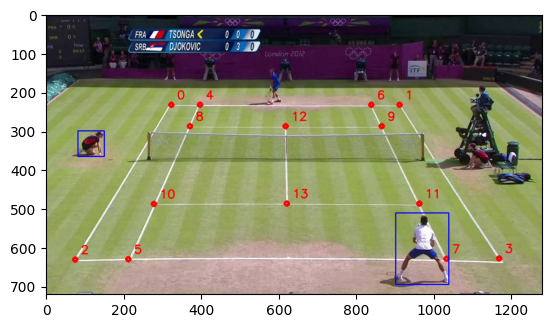

/home/florsanders/adl_ai_tennis_coach/data/tenniset/labels/V007_0021_annotated.mp4


In [17]:
out_path = visualize_segment_labels(os.path.join(segments_path, "V007_0021.mp4"))
print(out_path)

### Step 3 - Player Pose Detection